In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 12 Jul 2018

Distributed under the terms of the MIT License.

# Notebook for getting molecule parameters using RDKIT


In [3]:
import numpy as np
import pandas as pd
import os
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
import matplotlib.pyplot as plt
%aimport rdkit_functions

# Notes:
# Todo:
- timing
 - speed up reading: https://rdkit.blogspot.com/2016/09/avoiding-unnecessary-work-and.html

In [4]:
# molecule file dir
molecule_file = '/home/atarzia/psp/molecule_param/test_molecules.txt'
# output dir
output_dir = '/home/atarzia/psp/molecule_param/'

In [5]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [6]:
df, molecules, diameters = rdkit_functions.read_mol_txt_file(molecule_file)
rdkit_functions.produce_quick_fig_mol(molecules, output_dir+'test_molecules.pdf')

/home/atarzia/psp/molecule_param/test_molecules_1.pdf
/home/atarzia/psp/molecule_param/test_molecules_2.pdf


## Calculate all MWs

In [9]:
for m, smile in molecules.items():
    print(m, smile)
    # Read SMILES and add Hs
    mol = Chem.AddHs(Chem.MolFromSmiles(smile))
    MW = Descriptors.MolWt(mol)
    print('MW =', MW)

carbon dioxide C(=O)=O
MW = 44.009
oxygen O=O
MW = 31.998
nitrogen N#N
MW = 28.014
water O
MW = 18.015
methane C
MW = 16.042999999999996
ethene C=C
MW = 28.053999999999995
ethane CC
MW = 30.069999999999993
ethanol CCO
MW = 46.06900000000002
propene CC=C
MW = 42.08100000000002
n-propane CCC
MW = 44.09700000000002
1-butene CCC=C
MW = 56.10800000000002
n-butane CCCC
MW = 58.124000000000024
i-butene CC(=C)C
MW = 56.10800000000002
i-butane CC(C)C
MW = 58.124000000000024
1-butanol CCCCO
MW = 74.12299999999995
2,3-dimethylbutane CC(C)C(C)C
MW = 86.17799999999993
3-methylpentane CCC(C)CC
MW = 86.17799999999993
n-hexane CCCCCC
MW = 86.17799999999993
benzene c1ccccc1
MW = 78.11399999999996
ethyl-benzene CCc1ccccc1
MW = 106.16799999999994
para-xylene Cc1ccc(C)cc1
MW = 106.16799999999994
meta-xylene Cc1cccc(C)c1
MW = 106.16799999999994
ortho-xylene Cc1ccccc1C
MW = 106.16799999999994
mesitylene CC1=CC(=CC(=C1)C)C
MW = 120.19499999999992
1,2,4-trimethylbenzene CC1=CC(=C(C=C1)C)C
MW = 120.19499999999

## Calculate size and shape

In [6]:
rdkit_functions.calc_molecule_diameters(molecules, diameters, 
                                        out_dir=output_dir, vdwScale=0.8, boxMargin=4.0,
                                        spacing=0.6, show_vdw=False, plot_ellip=False,
                                        N_conformers=50, 
                                        show_conf=False)

molecule: carbon dioxide : SMILES: C(=O)=O
1 out of 25 done
molecule: oxygen : SMILES: O=O
2 out of 25 done
molecule: nitrogen : SMILES: N#N
3 out of 25 done
molecule: water : SMILES: O
4 out of 25 done
molecule: methane : SMILES: C
5 out of 25 done
molecule: ethene : SMILES: C=C
6 out of 25 done
molecule: ethane : SMILES: CC
7 out of 25 done
molecule: ethanol : SMILES: CCO
8 out of 25 done
molecule: propene : SMILES: CC=C
9 out of 25 done
molecule: n-propane : SMILES: CCC
10 out of 25 done
molecule: 1-butene : SMILES: CCC=C
11 out of 25 done
molecule: n-butane : SMILES: CCCC
12 out of 25 done
molecule: i-butene : SMILES: CC(=C)C
13 out of 25 done
molecule: i-butane : SMILES: CC(C)C
14 out of 25 done
molecule: 1-butanol : SMILES: CCCCO
15 out of 25 done
molecule: 2,3-dimethylbutane : SMILES: CC(C)C(C)C
16 out of 25 done
molecule: 3-methylpentane : SMILES: CCC(C)CC
17 out of 25 done
molecule: n-hexane : SMILES: CCCCCC
18 out of 25 done
molecule: benzene : SMILES: c1ccccc1
19 out of 25 d

## Results

In [7]:
threshold = 4.2
diffuse = {}
no_diffuse = {}
for name, smile in molecules.items():
    out_file = output_dir+name+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    min_diam = min(results['diam1'])
    mid_diam = min(results['diam2'])
    lit_d = df[df['molecule'] == name]['diffuse'].iloc[0]
    if lit_d == 't':
        if mid_diam <= threshold:
            print(name+':')
            print('can diffuse')
            print('min diameter =', round(min_diam, 3), 'angstrom')
            print('mid diameter =', round(mid_diam, 3), 'angstrom')
            diffuse[name] = smile
        else:
            print(name+':')
            print('cannot diffuse - lit says it can!')
            print('min diameter =', round(min_diam, 3), 'angstrom')
            print('mid diameter =', round(mid_diam, 3), 'angstrom')
            no_diffuse[name] = smile
    else:
        if mid_diam <= threshold:
            print(name+':')
            print('can diffuse - lit says it cannot!')
            print('min diameter =', round(min_diam, 3), 'angstrom')
            print('mid diameter =', round(mid_diam, 3), 'angstrom')
            diffuse[name] = smile
        else:
            print(name+':')
            print('cannot diffuse')
            print('min diameter =', round(min_diam, 3), 'angstrom')
            print('mid diameter =', round(mid_diam, 3), 'angstrom')
            no_diffuse[name] = smile
    print('-')

carbon dioxide:
can diffuse
min diameter = 2.715 angstrom
mid diameter = 2.916 angstrom
-
oxygen:
can diffuse
min diameter = 2.841 angstrom
mid diameter = 2.9 angstrom
-
nitrogen:
can diffuse
min diameter = 3.027 angstrom
mid diameter = 3.083 angstrom
-
water:
can diffuse
min diameter = 2.492 angstrom
mid diameter = 2.586 angstrom
-
methane:
can diffuse
min diameter = 3.004 angstrom
mid diameter = 3.425 angstrom
-
ethene:
can diffuse
min diameter = 2.794 angstrom
mid diameter = 3.852 angstrom
-
ethane:
can diffuse
min diameter = 3.62 angstrom
mid diameter = 3.937 angstrom
-
ethanol:
cannot diffuse - lit says it can!
min diameter = 3.629 angstrom
mid diameter = 4.336 angstrom
-
propene:
cannot diffuse - lit says it can!
min diameter = 3.464 angstrom
mid diameter = 4.28 angstrom
-
n-propane:
cannot diffuse - lit says it can!
min diameter = 4.12 angstrom
mid diameter = 4.562 angstrom
-
1-butene:
cannot diffuse
min diameter = 3.897 angstrom
mid diameter = 4.683 angstrom
-
n-butane:
cannot 

In [33]:
if len(diffuse) > 0:
    rdkit_functions.produce_quick_fig_mol(diffuse, output_dir+'diffuse_mol.pdf', 
                                          labels=False, mpr=5, ims=200)
if len(no_diffuse) > 0:
    rdkit_functions.produce_quick_fig_mol(no_diffuse, output_dir+'no_diffuse_mol.pdf', 
                                          labels=False, mpr=5, ims=200)

## Plot parity of kinetic diameters

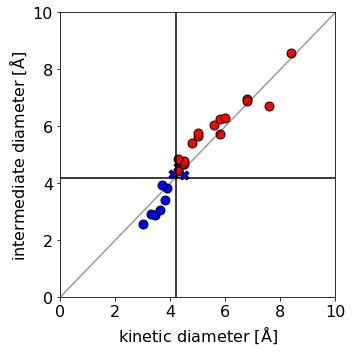

In [14]:
threshold = 4.2
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    try:
        kin_diam = float(diameters[name])
    except ValueError:
        print('no radius given for this molecule - skipped')
        continue
    out_file = output_dir+name+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    lit_d = df[df['molecule'] == name]['diffuse'].iloc[0]
    if lit_d == 't':
        if mid_diam <= threshold:
            C = 'b'
            M = 'o'
            E = 'k'
            D = 0.25
        else:
            C = 'b'
            M = 'X'
            E = 'k'
            D = 0.25
    else:
        if mid_diam <= threshold:
            C = 'r'
            M = 'X'
            E = 'k'
            D = 0.75
        else:
            C = 'r'
            M = 'o'
            E = 'k'
            D = 0.75
    ax.scatter(kin_diam, mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=80)
    
ax.axhline(y=threshold, c='k')
ax.axvline(x=threshold, c='k')
ax.plot(np.linspace(-1, 12, 2), np.linspace(-1, 12, 2), c='k', alpha=0.4)
# plot the limit from the two Sholl papers on diffusion
# ax.axvspan(4.0, 4.2, facecolor='r', alpha=0.5)


define_parity_plot_variables(ax,
                             title='',
                             xtitle='kinetic diameter [$\mathrm{\AA}$]',
                             ytitle='intermediate diameter [$\mathrm{\AA}$]',
                             xlim=(0, 10),
                             ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"parity.pdf", dpi=720,
            bbox_inches='tight')

## Plot categorical scatter

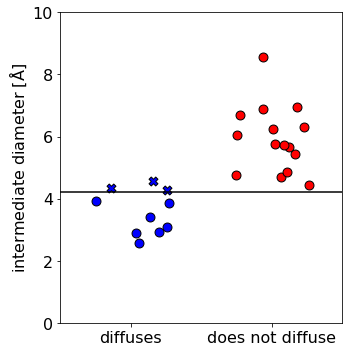

In [11]:
threshold = 4.2
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    lit_d = df[df['molecule'] == name]['diffuse'].iloc[0]
    if lit_d == 't':
        if mid_diam <= threshold:
            C = 'b'
            M = 'o'
            E = 'k'
            D = 0.25
        else:
            C = 'b'
            M = 'X'
            E = 'k'
            D = 0.25
    else:
        if mid_diam <= threshold:
            C = 'r'
            M = 'X'
            E = 'k'
            D = 0.75
        else:
            C = 'r'
            M = 'o'
            E = 'k'
            D = 0.75
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=80)
    
ax.axhline(y=threshold, c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

## Plot Shapes

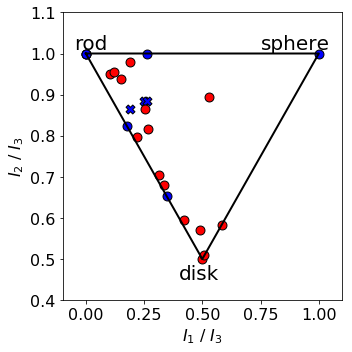

In [15]:
threshold = 4.2
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    lit_d = df[df['molecule'] == name]['diffuse'].iloc[0]
    if lit_d == 't':
        if mid_diam <= threshold:
            C = 'b'
            M = 'o'
            E = 'k'
            D = 0.25
        else:
            C = 'b'
            M = 'X'
            E = 'k'
            D = 0.25
    else:
        if mid_diam <= threshold:
            C = 'r'
            M = 'X'
            E = 'k'
            D = 0.75
        else:
            C = 'r'
            M = 'o'
            E = 'k'
            D = 0.75
    ax.scatter(np.average(results['ratio_1']),
               np.average(results['ratio_2']),
               c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=80)
    
ax.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax.text(0.75, 1.03, 'sphere', fontsize=20)
ax.text(0.4, 0.45, 'oblate', fontsize=20)
ax.text(-0.05, 1.03, 'prolate', fontsize=20)
define_parity_plot_variables(ax,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig.tight_layout()
fig.savefig(output_dir+"shape.pdf", dpi=720,
            bbox_inches='tight')

## Spacing tests:  -- done 18/7/18
- run ellipsoid tests 25 times with 10 conformers each time and save the average and std deviation of the min and mid diameter

In [22]:
# molecule: {spacing: (avg, std)}
spacing_tests_min = {'benzene': {'0.1': (0, 0),
                                 '0.2': (0, 0),
                                 '0.4': (3.3794289152145467 , 0.019673085424443428),
                                 '0.5': (3.3333897302564544 , 0.028678701518417928),
                                 '0.6': (3.2315745363725337 , 0.017849243469717994),
                                 '1.0': (2.849180995220388 , 0.04838637474340038)},
                     'n-hexane': {'0.1': (0, 0),
                                  '0.2': (0, 0),
                                  '0.4': (5.0835923862674495 , 0.06895603460636741),
                                  '0.5': (4.978275495360503 , 0.05683250141249099),
                                  '0.6': (4.873315126271812 , 0.06108305615909574),
                                  '1.0': (4.497290421763366 , 0.08750991331271302)},
                     '1,2,4-trimethylbenzene': {'0.1': (0, 0),
                                                '0.3': (4.840076609847893 , 0.045205419877336145),
                                                '0.4': (4.74736322402256 , 0.03994801793792416),
                                                '0.5': (4.641228188625925 , 0.06616635800790348),
                                                '0.6': (4.488226784532858 , 0.04847658400864577),
                                                '1.0': (3.9248371015184085 , 0.12679311000462484)}}

spacing_tests_mid = {'benzene': {'0.1': (0, 0),
                                 '0.2': (0, 0),
                                 '0.4': (6.649454451273829 , 0.013495748028405818),
                                 '0.5': (6.546971715975721 , 0.037964346782573745),
                                 '0.6': (6.525331194565837 , 0.029609796662037183),
                                 '1.0': (6.068867263161149 , 0.07011555279897945)},
                     'n-hexane': {'0.1': (0, 0),
                                  '0.2': (0, 0),
                                  '0.4': (5.727257044536465 , 0.1284078518182792),
                                  '0.5': (5.670823148829275 , 0.11718708499887756),
                                  '0.6': (5.5647520341975625 , 0.10709935627025727),
                                  '1.0': (5.32170216216025 , 0.13483968819479367)},
                     '1,2,4-trimethylbenzene': {'0.1': (0, 0),
                                                '0.3': (7.426353842175533 , 0.03786939839775834),
                                                '0.4': (7.333573135450377 , 0.04630508640316625),
                                                '0.5': (7.314738056193096 , 0.048482526890533326),
                                                '0.6': (7.226540741526308 , 0.07419202615800291),
                                                '1.0': (7.013051712007243 , 0.07598138464225354)}}
                     
markers = {'benzene': 'o', 'n-hexane': 'X', '1,2,4-trimethylbenzene': 'D'}
colours = {'benzene': 'k', 'n-hexane': 'r', '1,2,4-trimethylbenzene': 'b'}

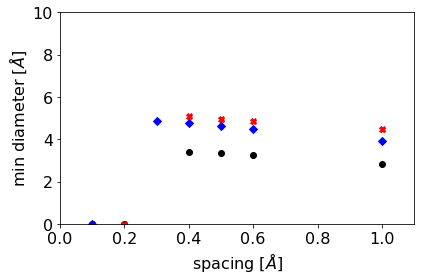

In [23]:
fig, ax = plt.subplots()
for mol in spacing_tests_min.keys():
    for key, val in spacing_tests_min[mol].items():
        sp = float(key)
        avg = val[0]
        std = val[1]
        ax.errorbar(sp, avg, c=colours[mol], yerr=std, fmt=markers[mol])

define_parity_plot_variables(ax,
                             title='',
                             xtitle='spacing [$\AA$]',
                             ytitle='min diameter [$\AA$]',
                             xlim=(0, 1.1),
                             ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"min_spacing.pdf", dpi=720,
            bbox_inches='tight')

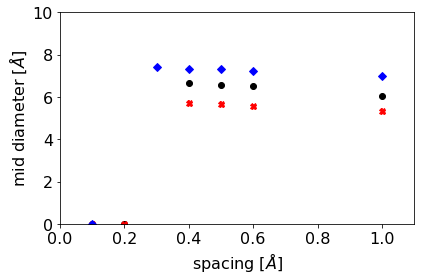

In [24]:
fig, ax = plt.subplots()
for mol in spacing_tests_mid.keys():
    for key, val in spacing_tests_mid[mol].items():
        sp = float(key)
        avg = val[0]
        std = val[1]
        ax.errorbar(sp, avg, c=colours[mol], yerr=std, fmt=markers[mol])

define_parity_plot_variables(ax,
                             title='',
                             xtitle='spacing [$\AA$]',
                             ytitle='mid diameter [$\AA$]',
                             xlim=(0, 1.1),
                             ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"mid_spacing.pdf", dpi=720,
            bbox_inches='tight')

## Conformer No. Tests - done 18/7/18
- 2 trials
- differ number of conformers
- spacing = 0.6

In [60]:
# molecule: {spacing: (avg, std)}
conformer_tests_min = {'benzene': {'1': (3.221373248755991 , 0.004852646654566861),
                                   '10': (3.2588304836940942 , 0.006956539037165754),
                                   '50': (3.2436940191596317 , 0.016198271266676167),
                                   '100': (3.2326218504059288 , 0.003853874440666649),
                                   '500': (3.2330473832007325 , 0.0018236559425053311)},
                     'n-hexane': {'1': (5.141141045458199 , 0.13304093800965688),
                                   '10': (4.957373679413936 , 0.023610168570660228),
                                   '50': (4.87212020107353 , 0.017040469280273474),
                                   '100': (4.911133486971741 , 0.01723649729619181),
                                   '500': (4.891902480769925 , 0.008404023636215285)},
                     '1,2,4-trimethylbenzene': {'1': (4.498871204493703 , 0.1362145494522462),
                                   '10': (4.478884245679016 , 0.015539006468946681),
                                   '50': (4.507169342491871 , 0.0035833227709809456),
                                   '100': (4.487331546112546 , 0.006343296733285264),
                                   '500': (4.493251428144968 , 0.0030979508775335063)}}

conformer_tests_mid = {'benzene': {'1': (6.473960279275529 , 0.024503187415663596),
                                   '10': (6.501792400073141 , 0.01924244928963903),
                                   '50': (6.528516395372385 , 0.008131803260291726),
                                   '100': (6.5407585651138795 , 0.002276161285552636),
                                   '500': (6.53315674537609 , 0.0012551802254567868)},
                     'n-hexane': {'1': (5.248219801680463 , 0.1596778847869671),
                                   '10': (5.512843592215781 , 0.00251194113303832),
                                   '50': (5.595576007199124 , 0.09552089437927647),
                                   '100': (5.576820296115795 , 0.04429024204647147),
                                   '500': (5.581235665531599 , 0.007401442176630635)},
                     '1,2,4-trimethylbenzene': {'1': (7.36604554182822 , 0.04078536880172745),
                                   '10': (7.276754072294647 , 0.052813283959488366),
                                   '50': (7.214263004894109 , 0.017593374853946298),
                                   '100': (7.229715994297686 , 0.003505550538929647),
                                   '500': (7.239862461826757 , 0.001030076037960903)}}
                     
markers = {'benzene': 'o', 'n-hexane': 'X', '1,2,4-trimethylbenzene': 'D'}
colours = {'benzene': 'k', 'n-hexane': 'r', '1,2,4-trimethylbenzene': 'b'}

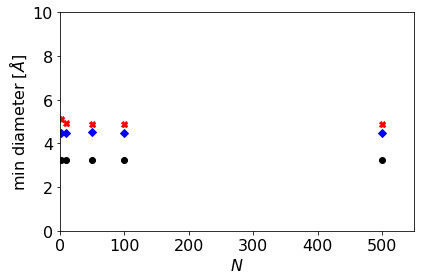

In [64]:
fig, ax = plt.subplots()
for mol in conformer_tests_min.keys():
    for key, val in conformer_tests_min[mol].items():
        sp = float(key)
        avg = val[0]
        std = val[1]
        ax.errorbar(sp, avg, c=colours[mol], yerr=std, fmt=markers[mol])

define_parity_plot_variables(ax,
                             title='',
                             xtitle='$N$',
                             ytitle='min diameter [$\AA$]',
                             xlim=(0, 550),
                             ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"min_conf.pdf", dpi=720,
            bbox_inches='tight')

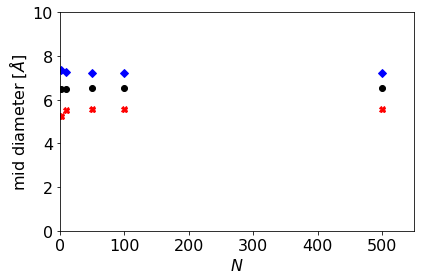

In [63]:
fig, ax = plt.subplots()
for mol in conformer_tests_mid.keys():
    for key, val in conformer_tests_mid[mol].items():
        sp = float(key)
        avg = val[0]
        std = val[1]
        ax.errorbar(sp, avg, c=colours[mol], yerr=std, fmt=markers[mol])

define_parity_plot_variables(ax,
                             title='',
                             xtitle='$N$',
                             ytitle='mid diameter [$\AA$]',
                             xlim=(0, 550),
                             ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"mid_conf.pdf", dpi=720,
            bbox_inches='tight')